# Convert time to circular
# Add holiday/Weekend flag

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime

import warnings
warnings.filterwarnings("ignore")

In [58]:
del df

In [59]:
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
df = pd.read_sql_query("SELECT * from Fires", conn)

In [60]:
features = ['CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 
            'DISCOVERY_TIME', 'FIRE_SIZE', 'FIRE_YEAR', 'LATITUDE','LONGITUDE', 
            'NWCG_REPORTING_AGENCY', 'OWNER_DESCR', 'STATE','STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR']

In [61]:
df = df[features]

In [62]:
df.head()

,CONT_DATE,CONT_DOY,CONT_TIME,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,FIRE_SIZE,FIRE_YEAR,LATITUDE,LONGITUDE,NWCG_REPORTING_AGENCY,OWNER_DESCR,STATE,STAT_CAUSE_CODE,STAT_CAUSE_DESCR
0,2453403.5,33.0,1730,2453403.5,33,1300,0.10,2005,40.036944,-121.005833,FS,USFS,CA,9.0,Miscellaneous
1,2453137.5,133.0,1530,2453137.5,133,0845,0.25,2004,38.933056,-120.404444,FS,USFS,CA,1.0,Lightning
2,2453156.5,152.0,2024,2453156.5,152,1921,0.10,2004,38.984167,-120.735556,FS,STATE OR PRIVATE,CA,5.0,Debris Burning
3,2453189.5,185.0,1400,2453184.5,180,1600,0.10,2004,38.559167,-119.913333,FS,USFS,CA,1.0,Lightning
4,2453189.5,185.0,1200,2453184.5,180,1600,0.10,2004,38.559167,-119.933056,FS,USFS,CA,1.0,Lightning


## Create Time and DOY and Day in the Week features as circular (using sin and cos)

In [ ]:
# https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

In [ ]:
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['DISCOVERY_MONTH'] = df['DISCOVERY_DATE'].dt.month
df['DISCOVERY_DAY'] = df['DISCOVERY_DATE'].dt.weekday

df['DISCOVERY_TIME'] = pd.to_datetime(df['DISCOVERY_TIME'], format='%H%M')

DAYS_IN_YEAR = 365
DAYS_IN_WEEK = 7

df['SIN_DISC_DOY'] = np.sin(2*np.pi*df['DISCOVERY_DOY']/DAYS_IN_YEAR)
df['COS_DISC_DOY'] = np.cos(2*np.pi*df['DISCOVERY_DOY']/DAYS_IN_YEAR)

df['SIN_DISC_WEEKDAY'] = np.sin(2*np.pi*df['DISCOVERY_DAY']/DAYS_IN_WEEK)
df['COS_DISC_WEEKDAY'] = np.cos(2*np.pi*df['DISCOVERY_DAY']/DAYS_IN_WEEK)

In [64]:
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.interpolate import interpn

# from:
# https://stackoverflow.com/questions/68035553/how-can-i-make-a-density-scatter-plot-with-a-2d-numpy-array
def density_scatter( x , y, ax = None, fig = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

In [65]:
# plot subplots of density_scatter

def plot_scatters(x, y, data, title=""):
    data = data[(~data[x].isna()) & (~data[y].isna())]
    fig, axs = plt.subplots(5,3)
    fig.suptitle(f'Fire Cause {title}')
    fig.set_figheight(20)
    fig.set_figwidth(20)
    for i in range(13):
        ax = axs[i // 3, i % 3]
        df = data[data['STAT_CAUSE_CODE'] == i+1]
        density_scatter(x=df[x].values, y=df[y].values, ax=ax, fig=fig, bins=(50,50))
        ax.set_title(f'CAUSE {i+1}')

    fig.tight_layout()
    plt.show()

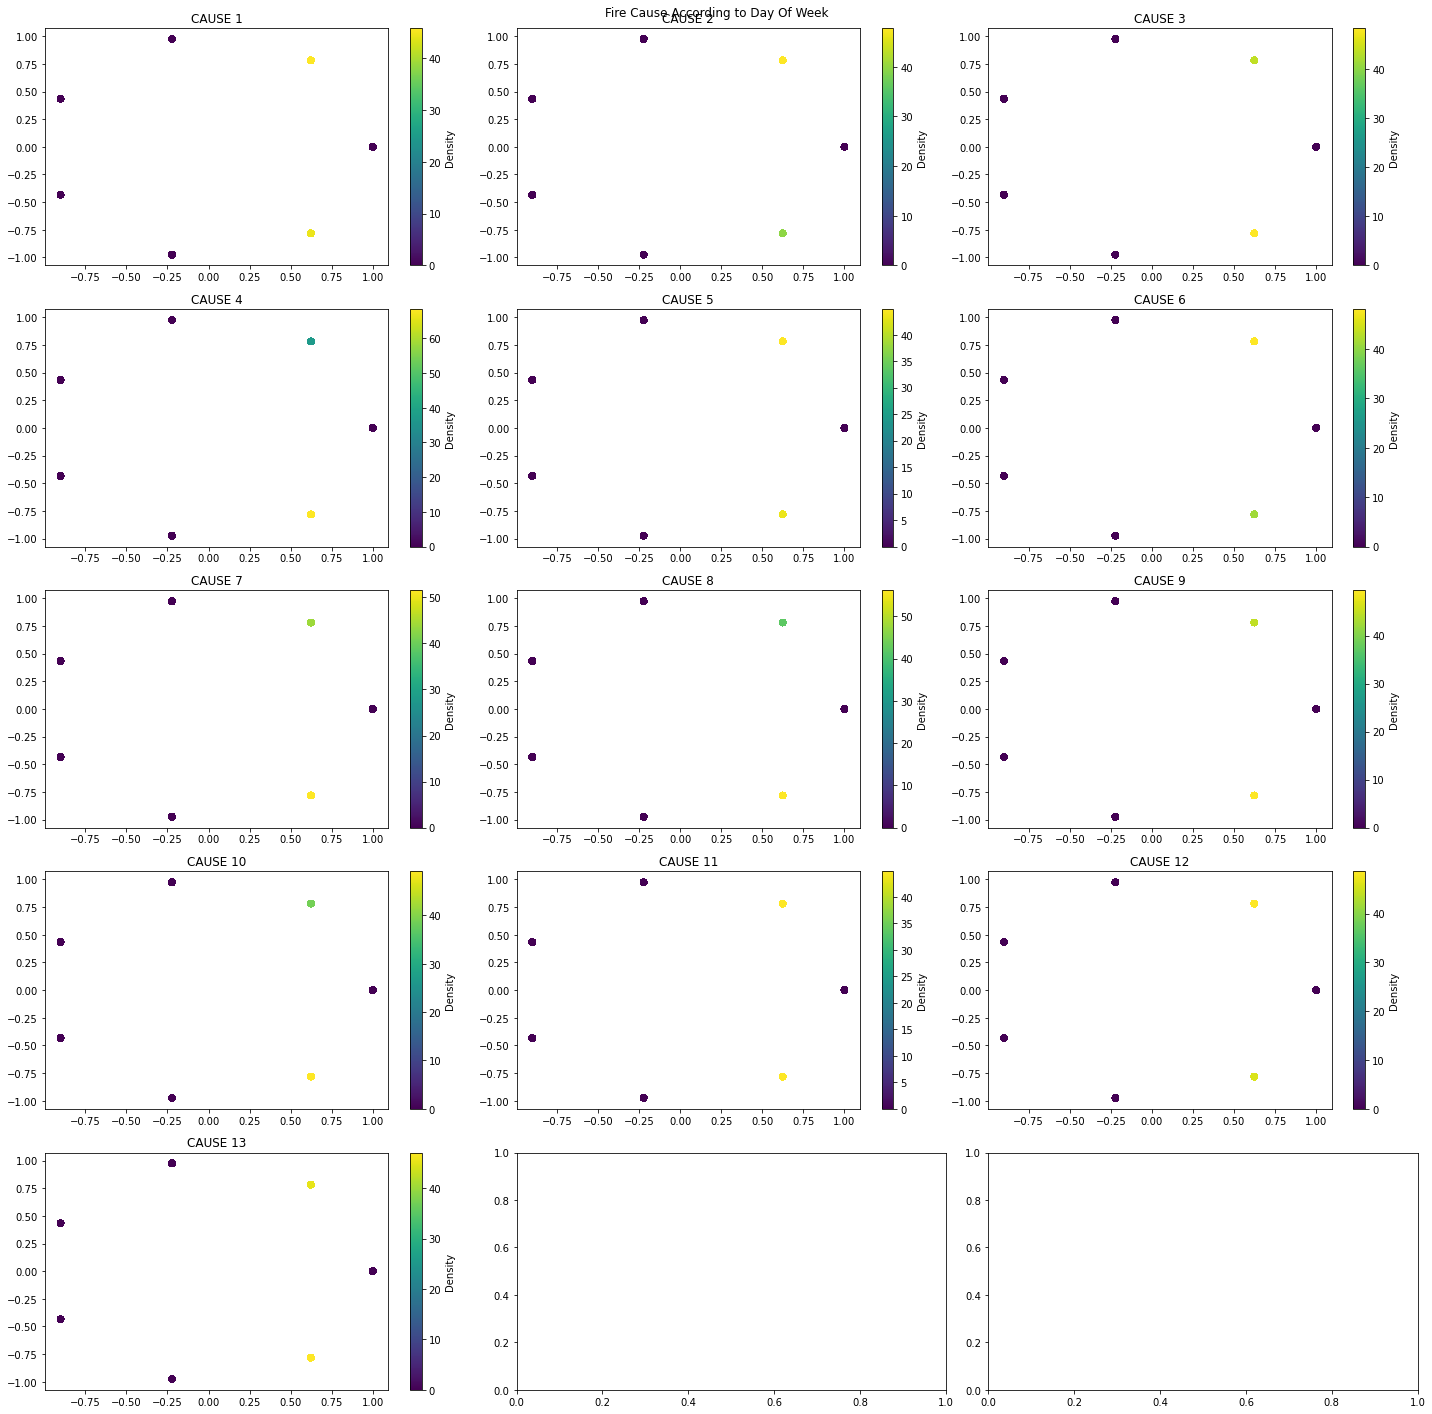

In [67]:
plot_scatters('COS_DISC_WEEKDAY', 'SIN_DISC_WEEKDAY', df, title='According to Day Of Week')

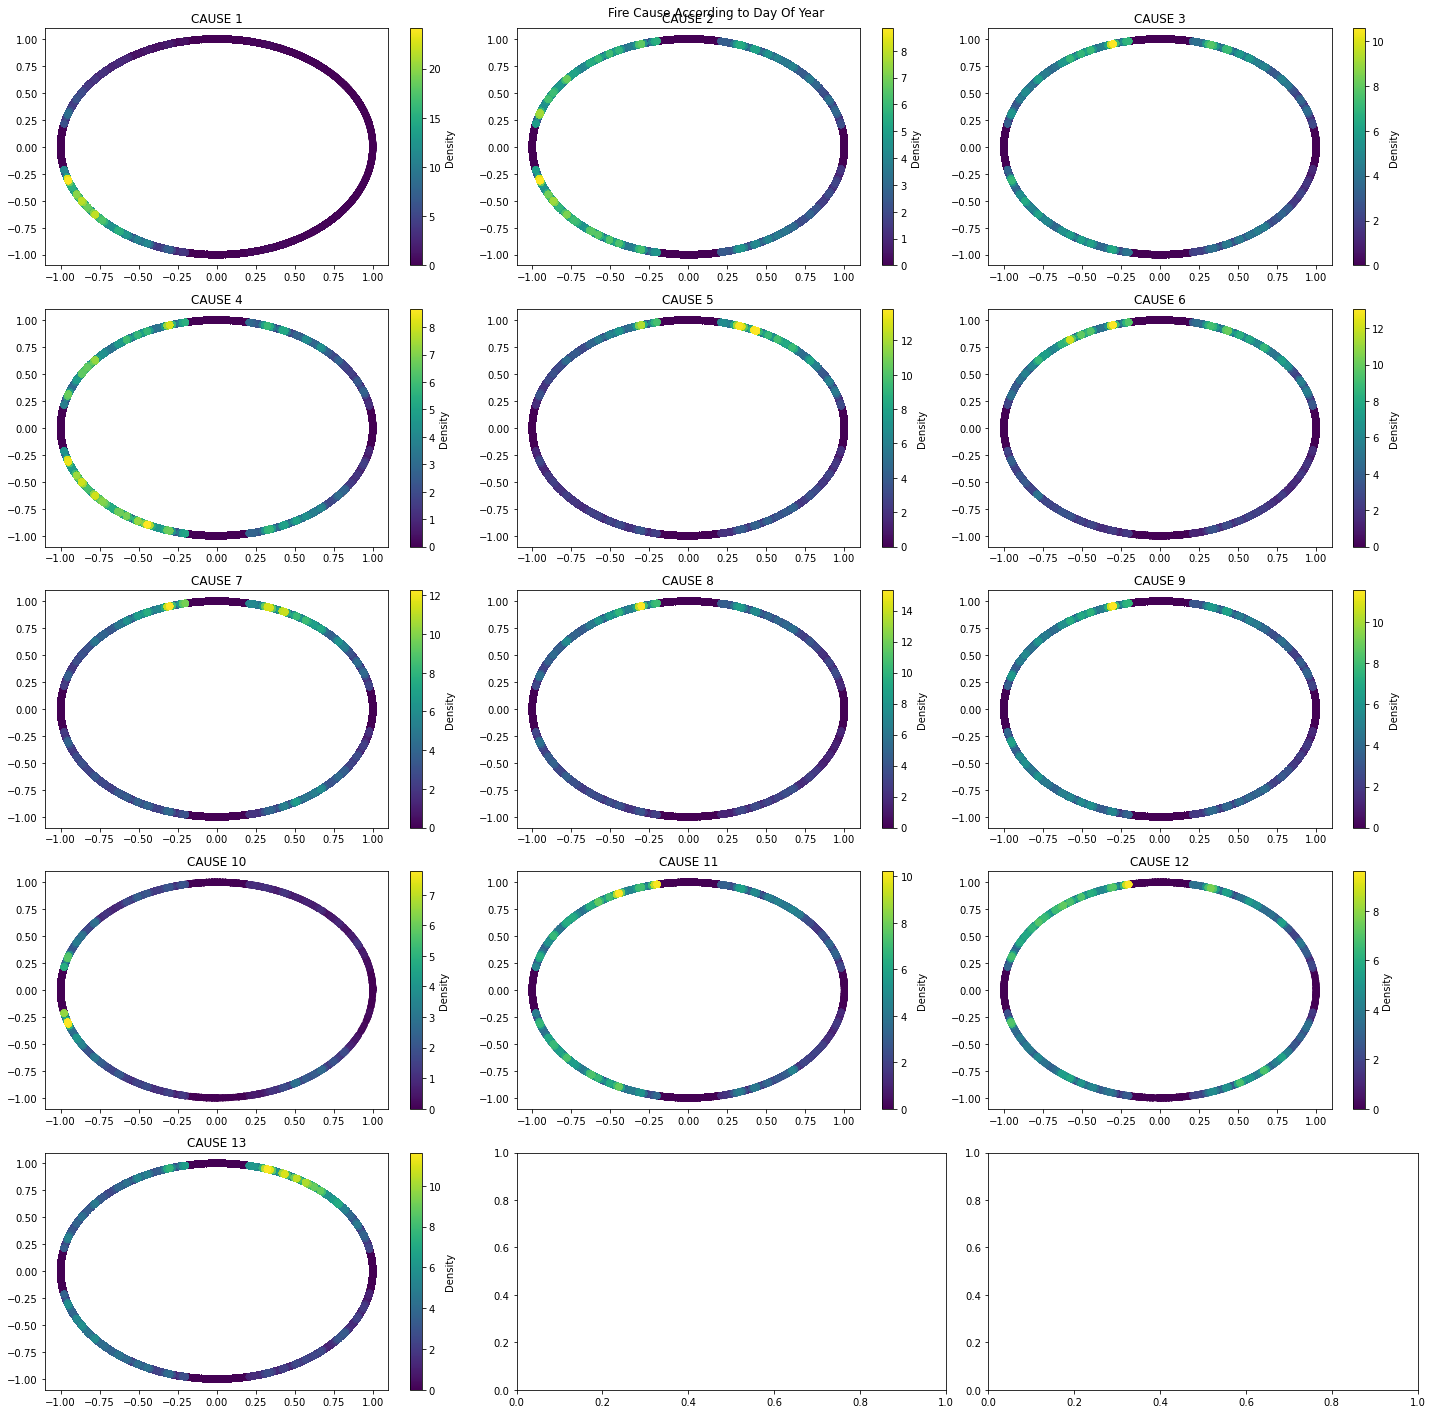

In [68]:
plot_scatters('COS_DISC_DOY', 'SIN_DISC_DOY', df, title='According to Day Of Year')

we can see that some cause are more common in some days than other.

# Special Days - Weekends and Holidays

In [26]:
# https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group
# Seaborn countplot with normalized y axis per group
def plot_proportion_plot(x, y='Proportion', hue=None, df=None, ax=None, normalize_by_x=True):
    normalize, other = hue, x
    (df[other]
      .groupby(df[normalize])
      .value_counts(normalize=True)
      .rename(y)
      .reset_index()
      .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, ax=ax))

In [15]:
df['IS_WEEKEND'] = (df['DISCOVERY_DAY'].isin([5, 6]))

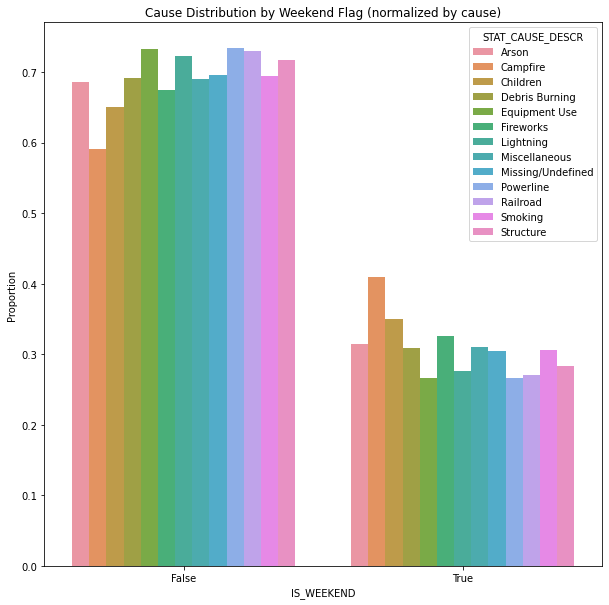

In [28]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
plot_proportion_plot(x='IS_WEEKEND', hue="STAT_CAUSE_DESCR", df=df, ax=ax)
ax.set_title('Cause Distribution by Weekend Flag (normalized by cause)')
plt.show()

more common in weekends is Campfire 

In [30]:
import holidays

In [31]:
us_holidays = holidays.UnitedStates()
df['IN_HOLIDAY'] = df['DISCOVERY_DATE'].apply(lambda x: x in us_holidays)

In [32]:
df['IN_HOLIDAY'].unique()

array([False,  True])

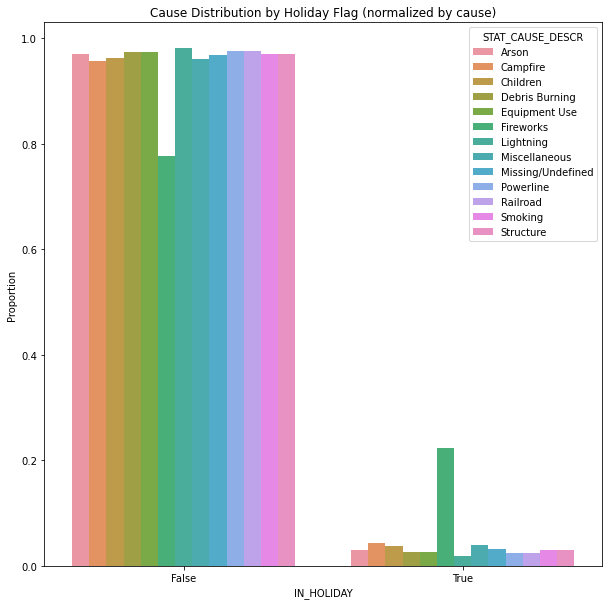

In [33]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
plot_proportion_plot(x='IN_HOLIDAY' ,hue="STAT_CAUSE_DESCR", df=df, normalize_by_x=False)
ax.set_title('Cause Distribution by Holiday Flag (normalized by cause)')
plt.show()

more common on holidays is Fireworks

In [43]:
#check for specific holydays
df['HOLIDAY'] = df['DISCOVERY_DATE'].apply(lambda x: us_holidays.get(x)).fillna("None")

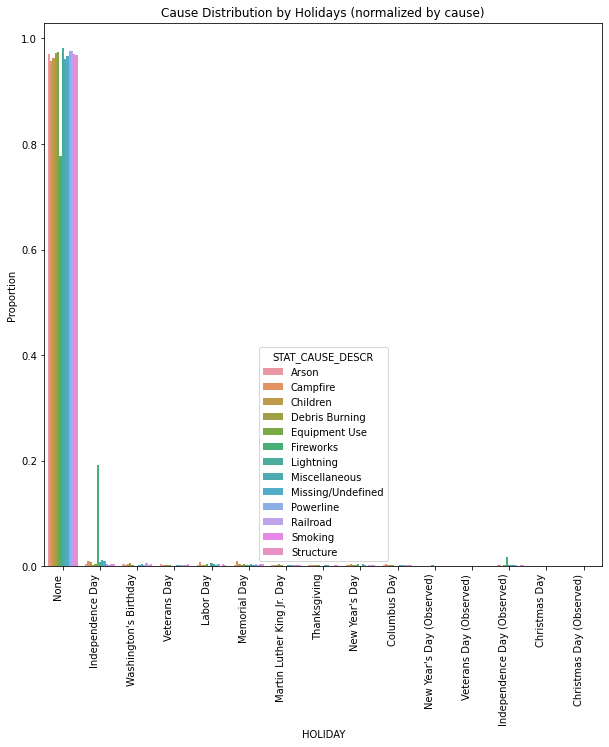

In [50]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
plot_proportion_plot(x='HOLIDAY' ,hue="STAT_CAUSE_DESCR", df=df, normalize_by_x=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Cause Distribution by Holidays (normalized by cause)')
plt.show()

We can see that independence day is the most relevant, 0.2 of fireworks are on it.<br> 
can use feature of is Independence day or not.

In [ ]:
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['DISCOVERY_MONTH'] = df['DISCOVERY_DATE'].dt.month
df['DISCOVERY_DAY'] = df['DISCOVERY_DATE'].dt.weekday

df['DISCOVERY_TIME'] = pd.to_datetime(df['DISCOVERY_TIME'], format='%H%M')

DAYS_IN_YEAR = 365
DAYS_IN_WEEK = 7

df['SIN_DISC_DAY'] = np.sin(2*np.pi*df['DISCOVERY_DOY']/DAYS_IN_YEAR)
df['COS_DISC_DAY'] = np.cos(2*np.pi*df['DISCOVERY_DOY']/DAYS_IN_YEAR)

df['SIN_DISC_WEEKDAY'] = np.sin(2*np.pi*df['DISCOVERY_DAY']/DAYS_IN_WEEK)
df['COS_DISC_WEEKDAY'] = np.cos(2*np.pi*df['DISCOVERY_DAY']/DAYS_IN_WEEK)

In [ ]:
# total time features from here:
# DISCOVERY_DATE - converted, create DISCOVERY_MONTH, DISCOVERY_DAY to get the features
time features = ['SIN_DISC_DOY', 'COS_DISC_DOY', 'SIN_DISC_WEEKDAY', 'COS_DISC_WEEKDAY', 'IS_WEEKEND', 'Is_Independence_Day']